# 1 - Imports & configuration

In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
from collections import Counter
from PIL import Image 

In [2]:
# CONFIG
TRAIN_DATA_PATH = "train"  
FLOWER_CLASSES = ["daisy","dandelion","rose","sunflower","tulip"]
TEST_SIZE = 0.20
RANDOM_STATE = 42
KNN_NEIGHBORS = 5

In [3]:
AUGMENT = True 
# Path for a single sample to visualize 
SAMPLE_IMAGE_PATH = "test/Image_60.jpg" 

# Output files
CONF_MATRIX_OUT = "confusion_matrix.png"
VAL_EXAMPLES_OUT = "val_examples.png"
SAMPLE_SIFT_OUT = "sample_sift_keypoints.png"

print("CONFIG:")
print(" TRAIN_DATA_PATH:", TRAIN_DATA_PATH)
print(" AUGMENT:", AUGMENT)
print(" SAMPLE_IMAGE_PATH:", SAMPLE_IMAGE_PATH)
print()

CONFIG:
 TRAIN_DATA_PATH: train
 AUGMENT: True
 SAMPLE_IMAGE_PATH: test/Image_60.jpg



# 2 - Gather image filepaths and labels

In [4]:
train_root = Path(TRAIN_DATA_PATH)
all_image_paths = []
all_labels = []
for cls_idx, cls_name in enumerate(FLOWER_CLASSES):
    folder = train_root / cls_name
    if not folder.exists():
        print(f"Warning: missing folder {folder} - skipping")
        continue
    jpgs = sorted(folder.glob("*.jpg"))
    for p in jpgs:
        all_image_paths.append(str(p))
        all_labels.append(cls_idx)

print(f"Found {len(all_image_paths)} images across {len(set(all_labels))} classes (jpg only).")

Found 2746 images across 5 classes (jpg only).


#  3 - Create SIFT detector and augmentation 

In [5]:

sift = cv2.SIFT_create()

def augment_image_cv2(img):
    """Return list of augmented images (including original) """
    outs = [img]
    # horizontal flip
    outs.append(cv2.flip(img, 1))
    # rotate 90, 180, 270
    outs.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
    outs.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    # optionally more augmentations can be added here
    return outs

#  4 - Extract mean-SIFT per image 

In [6]:

features = []
labels = []
feat_image_paths = []  # path per produced feature 
skipped_no_kp = 0
print("Extracting SIFT descriptors and computing mean-per-image features...")
for p, lbl in tqdm(zip(all_image_paths, all_labels), total=len(all_image_paths)):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Warning: unreadable image", p)
        continue

    # generate augmented images list (if enabled) — else just [img]
    if AUGMENT:
        imgs_to_process = augment_image_cv2(img)
    else:
        imgs_to_process = [img]

    for aug_i, im in enumerate(imgs_to_process):
        kps, desc = sift.detectAndCompute(im, None)
        if desc is None or len(desc) == 0:
            skipped_no_kp += 1
            continue
        mean_feat = desc.mean(axis=0)   # 128-dim vector
        features.append(mean_feat)
        labels.append(lbl)
        # record path with suffix to identify augmented samples (useful for debugging)
        if AUGMENT:
            feat_image_paths.append(f"{p}::aug{aug_i}")
        else:
            feat_image_paths.append(p)

features = np.array(features)
labels = np.array(labels)
print(f"Features extracted: {features.shape[0]}  (skipped {skipped_no_kp} descriptor-less images)")

# if features.shape[0] == 0:
#     raise RuntimeError("No descriptors were found in any image. Check dataset / OpenCV SIFT availability.")


Extracting SIFT descriptors and computing mean-per-image features...


100%|██████████████████████████████████████████████████████████████████████████████| 2746/2746 [05:54<00:00,  7.74it/s]

Features extracted: 10984  (skipped 0 descriptor-less images)


#  5 - Split into train / validation (stratified by label)

In [7]:

print("Splitting into train/validation...")
idx = np.arange(len(features))
train_idx, val_idx = train_test_split(idx, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE)

X_train = features[train_idx]
X_val = features[val_idx]
y_train = labels[train_idx]
y_val = labels[val_idx]
train_image_paths = [feat_image_paths[i] for i in train_idx]
val_image_paths = [feat_image_paths[i] for i in val_idx]

print(f"Train samples: {len(X_train)}   Validation samples: {len(X_val)}")
print("Train class counts:")
for i, cls in enumerate(FLOWER_CLASSES):
    print(f"  {cls}: {(y_train==i).sum()}")

Splitting into train/validation...
Train samples: 8787   Validation samples: 2197
Train class counts:
  daisy: 1603
  dandelion: 2067
  rose: 1591
  sunflower: 1584
  tulip: 1942


#  6 - Train KNN on mean-SIFT features

In [8]:

le = LabelEncoder()
# we want encoder with class names so inversion is easy
le.fit(FLOWER_CLASSES)
y_train_names = [FLOWER_CLASSES[int(i)] for i in y_train]
y_train_enc = le.transform(y_train_names)

knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS)
knn.fit(X_train, y_train_enc)
print("KNN trained on mean-SIFT features.")

KNN trained on mean-SIFT features.


#  7 - Evaluate on validation set & save confusion matrix

In [9]:

y_val_names = [FLOWER_CLASSES[int(i)] for i in y_val]
y_val_enc = le.transform(y_val_names)
y_val_pred_enc = knn.predict(X_val)
y_val_pred_names = le.inverse_transform(y_val_pred_enc)

acc = accuracy_score(y_val_enc, y_val_pred_enc)
print(f"Validation accuracy: {acc*100:.2f}%\n")
print("Classification report:")
print(classification_report(y_val_enc, y_val_pred_enc, target_names=le.classes_))

cm = confusion_matrix(y_val_enc, y_val_pred_enc)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (validation)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig(CONF_MATRIX_OUT, dpi=200, bbox_inches="tight")
plt.close()
print(f"Saved confusion matrix to: {CONF_MATRIX_OUT}")

Validation accuracy: 77.47%

Classification report:
              precision    recall  f1-score   support

       daisy       0.76      0.77      0.76       401
   dandelion       0.86      0.86      0.86       517
        rose       0.69      0.73      0.71       397
   sunflower       0.79      0.80      0.79       396
       tulip       0.76      0.71      0.74       486

    accuracy                           0.77      2197
   macro avg       0.77      0.77      0.77      2197
weighted avg       0.78      0.77      0.77      2197

Saved confusion matrix to: confusion_matrix.png


# 8 - Visualize a few validation examples (true vs predicted)

In [10]:

n_show = min(8, len(val_idx))
rng = np.random.default_rng(RANDOM_STATE)
sel = rng.choice(len(val_idx), size=n_show, replace=False)

cols = min(4, n_show)
rows = int(np.ceil(n_show/cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = np.array(axes).reshape(-1)
for ax in axes: ax.axis("off")

for i, s in enumerate(sel):
    img_path_entry = val_image_paths[s]
    # if augmented path like "path::aug1", extract real path
    real_path = img_path_entry.split("::")[0]
    img = cv2.imread(real_path, cv2.IMREAD_COLOR)
    if img is None:
        axes[i].text(0.5,0.5,"Image not found",ha="center")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    true_name = FLOWER_CLASSES[int(y_val[s])]
    pred_name = y_val_pred_names[s]
    color = "green" if true_name == pred_name else "red"
    axes[i].set_title(f"T: {true_name}\nP: {pred_name}", color=color, fontsize=10)
plt.tight_layout()
plt.savefig(VAL_EXAMPLES_OUT, dpi=200, bbox_inches="tight")
plt.close()
print(f"Saved validation examples grid to: {VAL_EXAMPLES_OUT}")

Saved validation examples grid to: val_examples.png


#  9 - Single-sample prediction & SIFT keypoint visualization (sample showcase)

In [11]:

print("Preparing single-sample showcase...")
sample_path = Path(SAMPLE_IMAGE_PATH)

if sample_path.exists() and sample_path.is_file():
    chosen = sample_path
else:
    # fallback: use first validation image (real path)
    if len(val_image_paths) > 0:
        chosen = Path(val_image_paths[0].split("::")[0])
        print(f"Sample path not found; using validation image: {chosen.name}")
    else:
        # last resort: use first available training image
        if len(train_image_paths) > 0:
            chosen = Path(train_image_paths[0].split("::")[0])
            print(f"No validation images; using training image: {chosen.name}")
        else:
            raise RuntimeError("No images available to use as a sample.")

img_color = cv2.imread(str(chosen), cv2.IMREAD_COLOR)
if img_color is None:
    raise FileNotFoundError(f"Could not read chosen sample image: {chosen}")

img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
kps, desc = sift.detectAndCompute(img_gray, None)

# draw rich keypoints (size/orientation)
img_kp = cv2.drawKeypoints(img_color, kps if kps is not None else [], None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# compute sample feature and predict
if desc is None or len(desc) == 0:
    # fallback: most common training class
    mode_label = Counter([FLOWER_CLASSES[int(i)] for i in y_train]).most_common(1)[0][0]
    sample_pred = mode_label
    print("No SIFT keypoints detected in sample image; using training-mode fallback.")
else:
    sample_feat = desc.mean(axis=0).reshape(1, -1)
    pred_enc = knn.predict(sample_feat)[0]
    sample_pred = le.inverse_transform([pred_enc])[0]

print(f"Predicted label for sample '{chosen.name}': {sample_pred}")

# save visualization
img_kp_rgb = cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,6))
plt.imshow(img_kp_rgb)
plt.axis("off")
plt.title(f"Sample: {chosen.name}   Predicted: {sample_pred}", fontsize=14)
plt.tight_layout()
plt.savefig(SAMPLE_SIFT_OUT, dpi=200, bbox_inches="tight")
plt.close()
print(f"Saved sample SIFT keypoints visualization to: {SAMPLE_SIFT_OUT}")

Preparing single-sample showcase...
Predicted label for sample 'Image_60.jpg': rose
Saved sample SIFT keypoints visualization to: sample_sift_keypoints.png


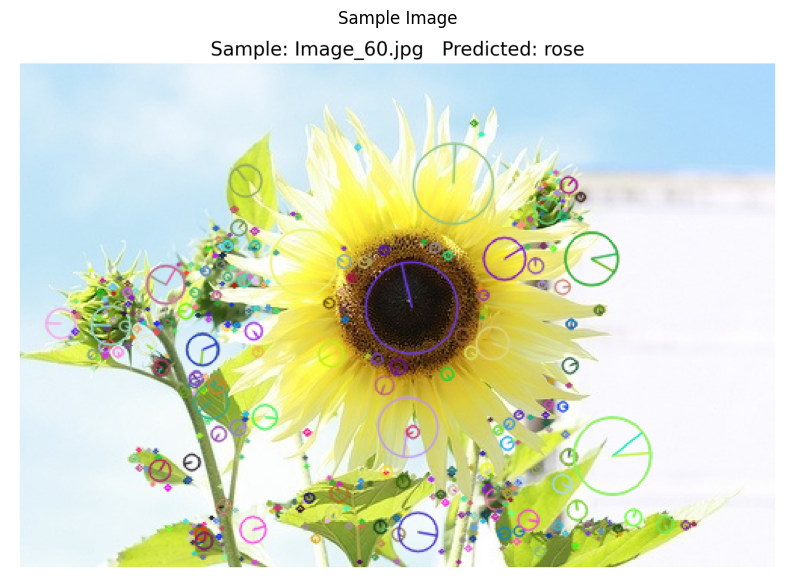

In [20]:
sample_image = Image.open('sample_sift_keypoints.png')

plt.figure(figsize=(10, 12))  
plt.imshow(sample_image)
plt.title('Sample Image')
plt.axis('off')  
plt.show()

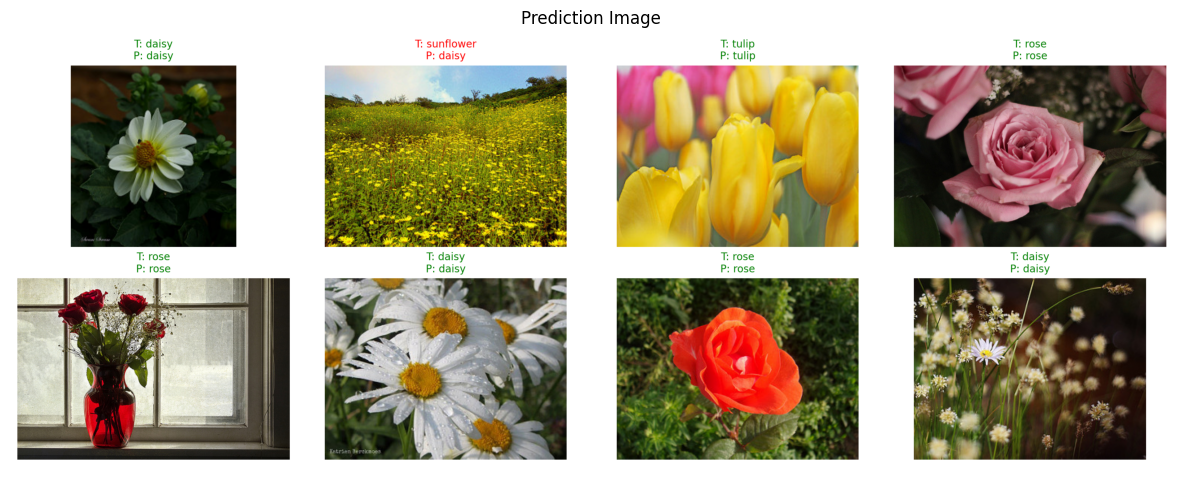

In [18]:
prediction_image = Image.open('val_examples.png')
# Display prediction image
plt.figure(figsize=(15, 15))  # Set figure size for the prediction image
plt.imshow(prediction_image)
plt.title('Prediction Image')
plt.axis('off')  # Hide axes
plt.show()

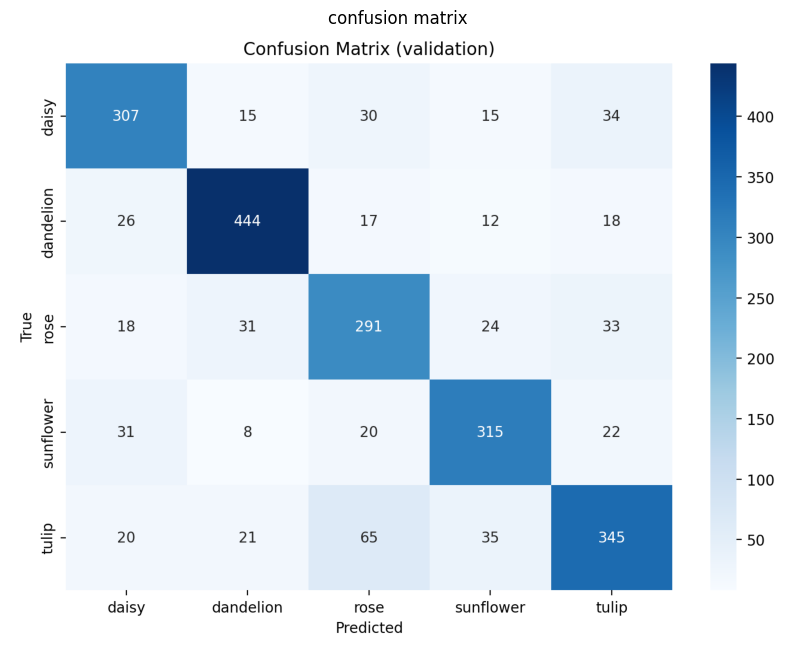

In [22]:
confusion_matrix = Image.open('confusion_matrix.png')
# Display prediction image
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix)
plt.title('confusion matrix')
plt.axis('off') 
plt.show()

In [25]:
print(f"Validation accuracy: {acc*100:.2f}%")

Validation accuracy: 77.47%
